# Тестирование потерь производительности ввода-вывода в  docker 

Это тесты нереплицируемых дисков в Yandex Cloud.

Показатели IOPS таких дисков намного выше и различия должны быть заметнее.

Вообще-то, показатели iops в Yandex Cloud [зависят от размера диска](https://cloud.yandex.ru/ru/docs/compute/concepts/storage-read-write).


## Гипотеза

Гипотеза в том, что дополнительные слои абстракции в docker не могут создать сколько-нибудь заметного замедления работы и поэтому эксплуатация в Docker баз данных и прочих приложений с интенсивным вводом-выводом, вполне разумная идея.

## Запуск тестов

Использована популярная программа fio. 
Задание записано в файле [task.ini](task.ini)

В первом тесте fio запускался на хосте.

Во втором случае, сначала собирался образ с добавленной программой fio на основе ОС идентичной хостовой. То есть, debian-slim.
Далее, запускалась команда:
```
docker run -v /data/:/data/ -v ./task.ini:/data/task.ini -it pavlozt/deb-fio:latest bin/bash
```

## Обработка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dirmark='./network-ssd-nonreplicated'

In [3]:
docker= pd.read_csv(f"{dirmark}/docker-mount/test1_iops.1.log",sep=',',names=['ts','iops','t','wtf1','wtf2'])
docker.head(3)

,ts,iops,t,wtf1,wtf2
0,250,5592,1,0,0
1,499,5473,1,0,0
2,749,5700,1,0,0


In [4]:
docker_read_iops=docker[docker.t==0][['iops']]
docker_write_iops=docker[docker.t==1][['iops']]

In [5]:
host= pd.read_csv(f"{dirmark}/host/test1_iops.1.log",sep=',',names=['ts','iops','t','wtf1','wtf2'])
host.head(3)

,ts,iops,t,wtf1,wtf2
0,250,5596,1,0,0
1,499,5590,1,0,0
2,749,5588,1,0,0


In [6]:
host_read_iops=host[host.t==0][['iops']]
host_write_iops=host[host.t==1][['iops']]

## Средние значения

Обычным способом сравнения "на глаз" является сравнение общего времени работы fio или средних показателей. 
В простых случаях различия очевидны, но что если отличия слишком малы? Чтобы убедиться, что случайный шум не повлиял на  эксперимент, необходима статистическая процедура.  

В этом тесте программа fio записывает набор средних значений за равные промежутки времени. Показатель "IOPS" (io per second) по своей сути является усредненным показателем. 

Просто сравним средние значения. Возможно ситуация когда показатели docker будут даже быстрее чем host.

In [7]:
print(docker_write_iops.iops.mean())
print(host_write_iops.iops.mean())

5590.3075
5590.083333333333


## Графики
сначала просто нарисуем iops чтобы оценить нет ли провалов вызванных огрехами тестирования.
И, возможно, даже увидим ненормальность распределения.

Один из графиков пустой, потому что для стабильности делался только лишь тест rw=write. 
Обычно график крутится вокруг декларированной в  Yandex Cloud производительности дисков.

<Axes: title={'center': 'host writes'}, xlabel='ts'>

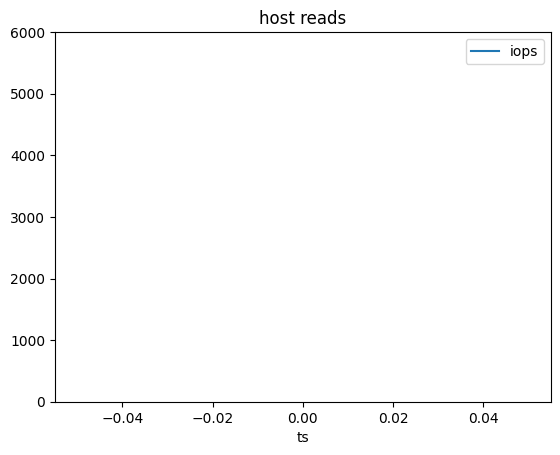

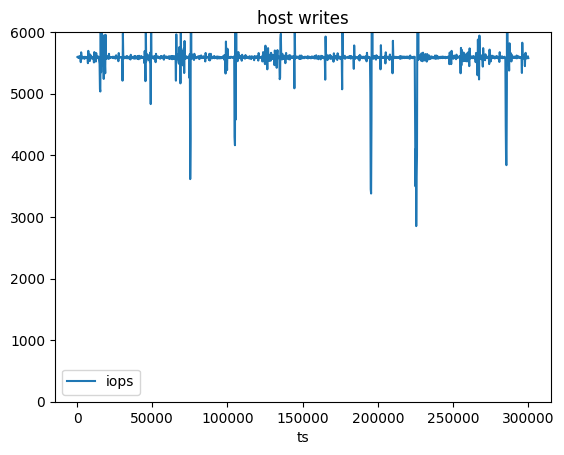

In [8]:
host[host.t==0].plot(x='ts',y='iops',title='host reads',ylim=[0,6000])
host[host.t==1].plot(x='ts',y='iops',title='host writes',ylim=[0,6000])

<Axes: title={'center': 'docker writes'}, xlabel='ts'>

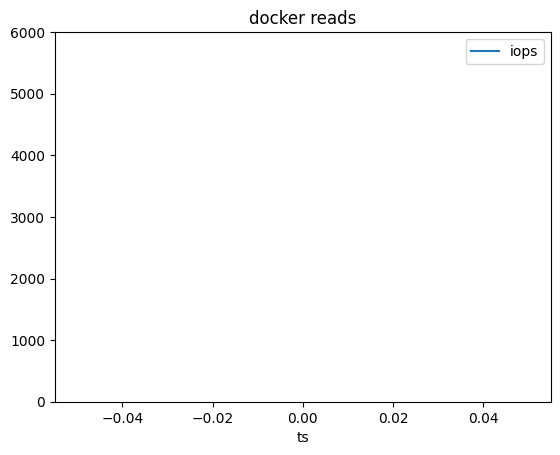

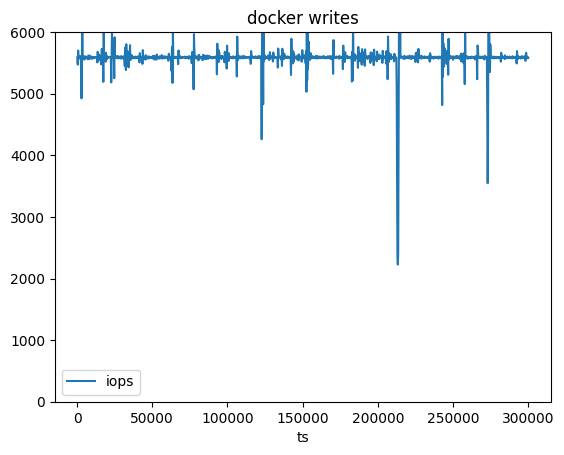

In [9]:
docker[docker.t==0].plot(x='ts',y='iops',title='docker reads',ylim=[0,6000])
docker[docker.t==1].plot(x='ts',y='iops',title='docker writes',ylim=[0,6000])

## Контроль характера данных

Нужно убедиться что нет событий-проседаний. 
То есть, никакой burst не повлиял на тест, а показатели более-менее держатся в расчетных пределах.

Если наблюдается аномалия - не повезло, **переделываем** тест. 

Обычно это не нужно, так как тест fio выполнялся с "прогревом", а графики исчерпания показателя burst контролировались в консоли облака. 

In [10]:
host_write_iops['test_type']='host_write_iops'
docker_write_iops['test_type']='docker_write_iops'

In [11]:
host_write_iops

,iops,test_type
0,5596,host_write_iops
1,5590,host_write_iops
2,5588,host_write_iops
3,5596,host_write_iops
4,5580,host_write_iops
...,...,...
1195,5596,host_write_iops
1196,5588,host_write_iops
1197,5580,host_write_iops
1198,5608,host_write_iops


In [12]:
data = pd.concat([host_write_iops, docker_write_iops])
data

,iops,test_type
0,5596,host_write_iops
1,5590,host_write_iops
2,5588,host_write_iops
3,5596,host_write_iops
4,5580,host_write_iops
...,...,...
1195,5580,docker_write_iops
1196,5586,docker_write_iops
1197,5584,docker_write_iops
1198,5596,docker_write_iops


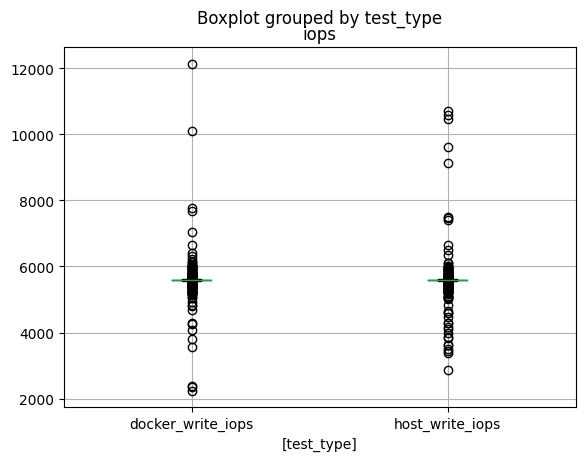

In [13]:
data.boxplot(by='test_type')
plt.show()

Выбросов многовато. Посмотрим еще и гистограмму.

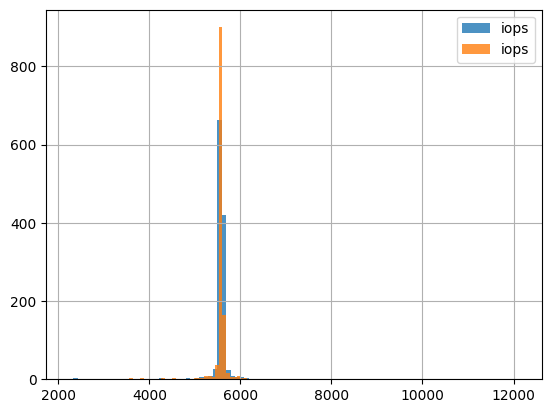

In [14]:
docker_write_iops['iops'].hist(bins=100,alpha=0.8,legend=True)
host_write_iops['iops'].hist(bins=100,alpha=0.8,legend=True)
#data.hist(column='iops',by='test_type',bins=100,legend=True)
plt.show()

## Еще немного графиков в другом стиле

In [15]:
import seaborn as sns

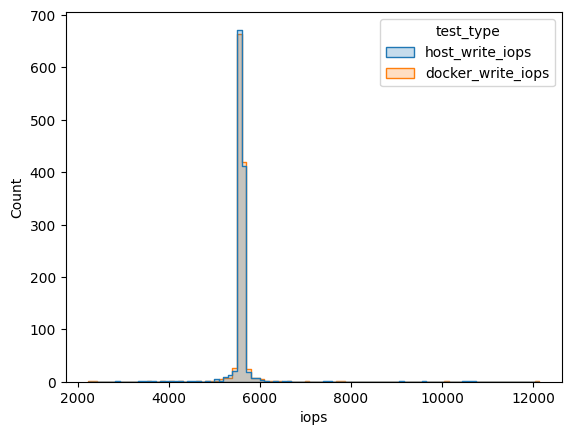

In [16]:
sns.histplot(data, x="iops", hue="test_type",element="step",bins=100);

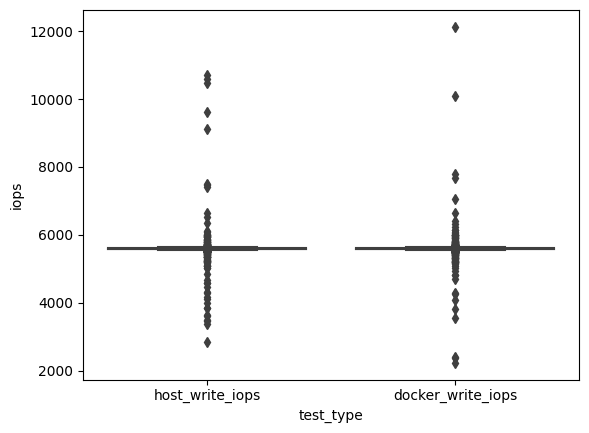

In [17]:
sns.boxplot(data=data, x="test_type", y="iops");

Для обычных статистических тестов  важно иметь нормально распределенные данные.

Возможно, произошли какие-то аномалии при сборе данных и хвосты слишком "тяжелые"
Самый простой способ - обрезать выбросы. 
Так же отрисуем этот ограниченный набор данных, чтобы оценить форму распределения визуально.

In [18]:
visualdata=data[(data.iops > 5400) & (data.iops < 5800)]

Теперь все повторяем:

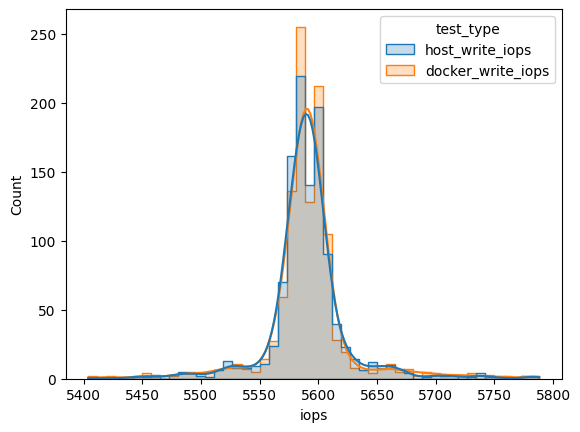

In [19]:
sns.histplot(visualdata, x="iops", hue="test_type",element="step",bins=50,kde=True);

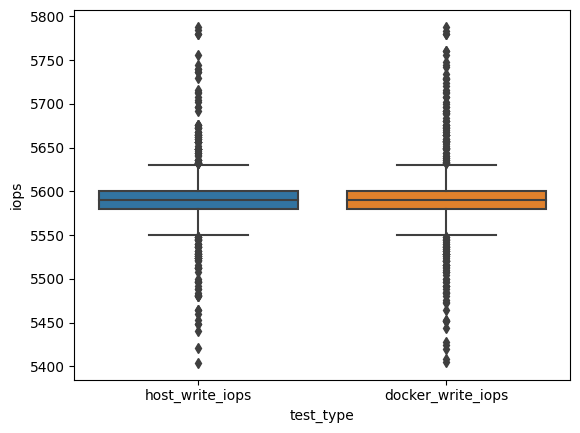

In [22]:
sns.boxplot(data=visualdata, x="test_type", y="iops");

## Статистические тесты

делаем обычный t-test

In [23]:
from scipy import stats

In [24]:
stats.ttest_ind( host_write_iops['iops'],docker_write_iops['iops'],alternative='greater')

TtestResult(statistic=-0.015355335418615168, pvalue=0.5061250131151583, df=2398.0)

с такими показателями  считается,  что **отличий нет**.

## Линейная модель (в стиле R)

сначала придется подготовить данные для этого стиля:
Поменяем тип факторной переменной "test_type" 

In [25]:
data.loc[:,'test_type']=data['test_type'].map({'docker_write_iops':0,'host_write_iops':1})
data.head(3)

,iops,test_type
0,5596,1
1,5590,1
2,5588,1


In [26]:
import statsmodels as sm
import statsmodels.formula.api as smf

In [27]:
mod = smf.ols(formula='iops ~ test_type', data=data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   iops   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                 0.0002358
Date:                Sat, 06 Jan 2024   Prob (F-statistic):              0.988
Time:                        16:59:15   Log-Likelihood:                -17515.
No. Observations:                2400   AIC:                         3.503e+04
Df Residuals:                    2398   BIC:                         3.505e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       5590.3075     10.323    541.

p-value не достигло даже самой слабой  из общепринятых планок.

# Вывод
Даже при использовании максимально быстрых дисков в Yandex Cloud с примерно 5000 iops невозможно наблюдать статистически  значимые отличия.

Желательно провести тестирование на физическом ПК с локальными быстрыми SSD.